In [11]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from mobo.utils import calculate_var

In [12]:
# from mobo.surrogate_model import BoTorchSurrogateModelReapeat, BoTorchSurrogateModel
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [13]:
# .\result\exp4d\optimization_4\marsdet\0\state_dict_noise.pt

# path = Path("../result/exp4d/unroll_new/marsdet/0/")
# path = Path("../result/exp/unroll_new/raqnehvi/0/")
# path = Path("../result/peaksS5R3/default/mars/0/")
# path = Path("../result/peaks/default/qnehvi/0/")
# path = Path(r"..\good results\peaks\risk-averse1\qnehvi\0")
path = Path("../result/peaks/default/mars/0/")

# state_dict = torch.load(path / "state_dict.pt")
# state_dict_noise = torch.load(path / "state_dict_noise.pt")

eval_samples = pd.read_csv(path / "EvaluatedSamples.csv")
approx_all_df = pd.read_csv(path / "ApproximationAll.csv")

# paretoEval_list.append(pd.read_csv(csv_folder + "ParetoFrontEvaluated.csv"))
# with open(csv_folder + "args.yml") as f:
#     yml_list.append(yaml.load(f, Loader=yaml.SafeLoader))
# paretoGP_list.append(pd.read_csv(csv_folder + "ParetoFrontApproximation.csv"))
paretoGP = pd.read_csv(path / "ParetoFrontApproximation.csv")
paretoEval = pd.read_csv(path / "ParetoFrontEvaluated.csv")
paretoApprox = pd.read_csv(path / "ParetoFrontApproximation.csv")

def get_data_of_step(pareto_approx_df, selected_iteration):
    filtered_data = pareto_approx_df[pareto_approx_df["iterID"] == selected_iteration]
    return filtered_data

eval_samples = pd.read_csv(path / "EvaluatedSamples.csv")
eval_samples.columns.to_list()

args_yaml = path / "args.yml"
args = yaml.safe_load(args_yaml.open("r"))

batch_size = args["general"]["batch_size"]
init_samples = args["general"]["n_init_sample"]
n_obj = args["general"]["n_obj"]

sub=0
algo_name = args["general"]["algo"]
if "det" in algo_name:
    sub=1

if "exp" in args["general"]["problem"]:
    eval_samples = eval_samples[~(eval_samples["iterID"] == eval_samples["iterID"].max())]
    sub = 1
    
n_obj -= sub
    
# bool array for sobol experiments vs optimization
sobol = np.where(eval_samples["iterID"] == 0, True, False)


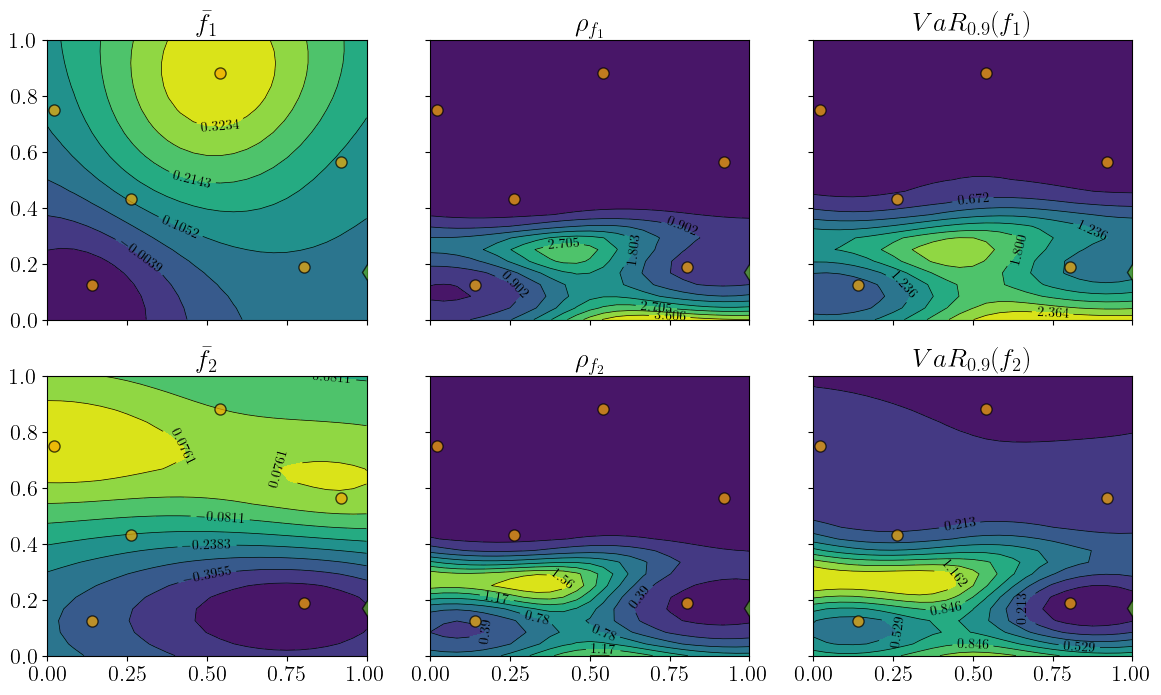

In [14]:
# %config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    # font size
    "font.size": 16,
})

colors = defaultColors

# Assuming 'approx_all_i' is your DataFrame and 'n_grid' is defined
n_grid = 25


objective_list = list(range(1,n_obj+1))
data_keys = ["F_", "rho_F_", "mvar_F_"]

iter = approx_all_df["iterID"].max()

approx_all_i = approx_all_df[approx_all_df["iterID"] == iter]
# Data reshaping
x = approx_all_i["x1"].values.reshape((n_grid, n_grid))
y = approx_all_i["x2"].values.reshape((n_grid, n_grid))

fig, axs = plt.subplots(len(objective_list), len(data_keys), figsize=(14, 8))

for i, obj_idx in enumerate(objective_list):
    for j, key in enumerate(data_keys):
        # Construct the key for the current iteration
        current_key = f"{key}{obj_idx}"
        # Reshape the data for the current plot
        z = approx_all_i[current_key].values.reshape((n_grid, n_grid))
        levels = np.linspace(z.min(), z.max(), 10)
        # Create contour plot
        img = axs[i, j].contourf(x[0], y[:, 0], z, levels=levels, cmap="viridis")
        c = axs[i, j].contour(x[0], y[:, 0], z, levels=levels, colors='black', linestyles='solid', linewidths=0.5)
        axs[i, j].clabel(c, c.levels[::2], inline=True, fontsize=10, colors='black', zorder=100)
        
        # Sobol experiments
        axs[i, j].plot(eval_samples[sobol]["x1"], eval_samples[sobol]["x2"], alpha=0.7, color=colors[0], markeredgecolor="black", linestyle="None", marker="o", markersize=8,
                        zorder=5, label="Sobol")
        # Optimization experiments
        axs[i, j].plot(eval_samples[~sobol]["x1"], eval_samples[~sobol]["x2"], alpha=0.7, color=colors[1], markeredgecolor="black", linestyle="None", marker="d", markersize=8,
                        zorder=5, label="Optimization")
            
        # Latex formatting
        if key == "F_":
            axs[i, j].set_title(f"$\\bar{{f}}_{obj_idx}$")
        if key == "rho_F_":
            axs[i, j].set_title(f"$\\rho_{{f_{obj_idx}}}$")
        if key == "mvar_F_":
            axs[i, j].set_title(f"$VaR_{{0.9}}({{f_{obj_idx}}})$")

# only show axis labels on the bottom row
for ax in axs.flat:
    ax.label_outer()

# plt.tight_layout()
plt.show()

path_folder = Path("./Plots") / path.parts[2]
path_folder.mkdir(exist_ok=True, parents=True)
# plt.savefig(path_folder / ("_".join(path.parts[3:-1]) + "_IOplot.pdf"), dpi=600, format="pdf")

